# Soustraction de l’image moyenne sur une vidéo

## Objectif
L’objectif de cette tâche est de faciliter la détection de la balle sur l’image en supprimant ce qui est superflu et pourrait gêner la détection de la balle.

## Hypothèses de travail
Le cadre de la vidéo est fixe.
Les images de la vidéo sont encodées en RGB.

## Méthodologie et code
La vidéo est traitée image par image. L’idée générale est de calculer l’image moyenne des images encadrant l’image traitée. La taille de l’intervalle est donnée par la variable tailleMoy. Par exemple si la taille de l’intervalle est de 9, on calcule l’image moyenne avec les 4 images précédentes, l’image que l’on souhaite traiter et les 4 images suivantes. Ensuite, on soustrait à l’image traitée cette image moyenne, ce qui permet de supprimer totalement ce qui est fixe sur la vidéo et d’atténuer ce qui bouge peu. 
Par soustraction d’image on entend soustraire les valeurs de rouge, bleu et vert de chaque pixel de l’image.
Dans la mesure où ce traitement ne nécessite que quelques images après l’image en cours de traitement, il peut être fait en temps réel.
Dans un premier on travaille sur une image, puis sur une suite d’image enregistrées sur un ordinateur. Ensuite nous avons transposé la démarche à une vidéo enregistrée et à une vidéo filmée depuis une caméra.
Ce programme nécessite les modules python suivants : os, numpy, PIL (module Image) et OpenCV (cv2).

In [2]:
import os, numpy, PIL
from PIL import Image
import cv2
import time

### Travail sur des images
On définit les deux fonctions suivantes qui reçoivent des listes d’images (de la classe Image du module PIL). La soustraction de l’image est faire à l’aide du module OpenCV qui nécessite une conversion des tableaux de RGB en BGR (https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format , 1ère réponse).

In [3]:
# --- Ouverture et chargement des images
adresse=os.getcwd()+"\\ImTest2"
allfiles=os.listdir(adresse)
imlistString=[filename for filename in allfiles if  filename[-4:] in [".png",".PNG"]] #Juste des string des fichiers

print(imlistString)
imlistPIL= [Image.open(adresse+"\\"+im).convert('RGB') for im in imlistString]

 # --- Test sur une image --- 
imlistPIL[len(imlistPIL)//2].show()

['TT01.PNG', 'TT02.PNG', 'TT03.PNG', 'TT04.PNG', 'TT05.PNG', 'TT06.PNG', 'TT07.PNG', 'TT08.PNG', 'TT09.PNG', 'TT10.PNG', 'TT11.PNG', 'TT12.PNG', 'TT13.PNG', 'TT14.PNG', 'TT15.PNG', 'TT16.PNG', 'TT17.PNG', 'TT18.PNG', 'TT19.PNG', 'TT20.PNG', 'TT21.PNG', 'TT22.PNG', 'TT23.PNG', 'TT24.PNG', 'TT25.PNG', 'TT26.PNG', 'TT27.PNG', 'TT28.PNG', 'TT29.PNG', 'TT30.PNG']


In [4]:
def calcImageMoyenne(imListPIL): # Renvoie array
    w,h=imListPIL[0].size
    arr=numpy.zeros((h,w,4),numpy.float)
    images = numpy.array([numpy.array(image) for image in imListPIL])
    # Round values in array and cast as 8-bit integer
    arr=numpy.array(numpy.mean(images,axis=(0)),dtype=numpy.uint8)
    return arr

imM = Image.fromarray(calcImageMoyenne(imlistPIL))
imM.show()

In [5]:
def subImageMoy(imListPIL):
    n=len(imListPIL)
    imCentre=numpy.array(imListPIL[n//2],dtype=numpy.uint8)
    imMoy=calcImageMoyenne(imListPIL)
    
    # Conversion en tableau pour OpenCV
    imCentreCV2 = imCentre[:,:,::-1].copy()
    imMoyCV2 = imMoy[:,:,::-1].copy()
    imSub = cv2.subtract(imCentreCV2,imMoyCV2)
    return imSub

imSM = subImageMoy(imlistPIL)
cv2.imshow('Image Moyenne',imSM)

Ensuite, il ne reste plus qu’à ouvrir et stocker toutes les images dans une liste en envoyant dans la fonction subImageMoy une sous liste contenant l’image à traiter au centre. Le cas des images « en bord » de liste n’a pas été traité.

In [ ]:
tailleMoy=9

imlistMoy = [0]*tailleMoy
imlistSubMoy = [0]*(len(imlistPIL)-tailleMoy+1)
for i in range(tailleMoy//2,len(imlistPIL)-tailleMoy//2):
    # On selectionne les images autour de celle centrale
    for j in range(tailleMoy):
        imlistMoy[j]=imlistPIL[j+i-tailleMoy//2]
    imlistSubMoy[i-tailleMoy//2]=subImageMoy(imlistMoy)

# Affichage des images
for i in range(len(imlistSubMoy)):
    cv2.imshow("Image "+str(i),imlistSubMoy[i])

### Travail sur une vidéo enregistrée
Pour la lecture et l’écriture de vidéo, on utilise le module OpenCV. On définit dans un premier temps une fonction qui crée une liste d’images (plus précisément de tableaux représentant des images) à partir de l’adresse de la vidéo en prenant en paramètre le nombre d’images à sauvegarder par seconde (potentiellement différent de celui de la vidéo).

In [ ]:
def video2listImage(adresseVideo,saveFPS): # Renvoie une liste d'image sous forme d'array
    video = cv2.VideoCapture(adresseVideo)
    videoFPS = video.get(cv2.CAP_PROP_FPS)
    fps = min(saveFPS,videoFPS) # On peut enregistrer moins d'images en mettant un saveFPS inférieur mais pas l'inverse
    fps=videoFPS
    imlist=[]
    continuer = True
    compteur=0
    while continuer:
        isRead , frame = video.read()  # A-t-on lu une image et si oui cette image
        if not isRead:
            continuer = False
        else:
            frameTimeCode = compteur/videoFPS
            if frameTimeCode*fps%1==0: # Si le timeCode*le fps d'enregistrement est entier, on sauvegarde l'image
                imlist.append(frame)
            compteur+=1
    return imlist

Les deux fonctions précédentes sont redéfinies pour prendre en argument une liste d’array BGR et on crée également une fonction appliquant l’algorithme de soustraction sur une liste d’image (reprise du code précédent) :

In [ ]:
def calcImageMoyenneArr(imListArr): # Renvoie array
    w,h=len(imListArr[0]), len(imListArr[0][0])
    arr=numpy.zeros((h,w,4),numpy.float)
    images = numpy.array([image for image in imListArr])
    # Round values in array and cast as 8-bit integer
    arr=numpy.array(numpy.mean(images,axis=(0)),dtype=numpy.uint8)
    return arr

def subImageMoyArr(imListArr): # Renvoie un tableau OpenCV
    n=len(imListArr)
    imCentre=imListArr[n//2]
    imMoy=calcImageMoyenneArr(imListArr)
    imSub = cv2.subtract(imCentre,imMoy)
    return imSub

def SubImageMoySurListe(imList,tailleMoy):
    imlistMoy = [0]*tailleMoy
    imlistSubMoy = [0]*(len(imList)-tailleMoy+1)
    for i in range(tailleMoy//2,len(imList)-tailleMoy//2):
        # On selectionne les images autour de celle centrale
        for j in range(tailleMoy):
            imlistMoy[j]=imList[j+i-tailleMoy//2]
        imlistSubMoy[i-tailleMoy//2]=subImageMoyArr(imlistMoy)
    return imlistSubMoy

videoReadFile="TT Real Speed.mp4"
imList = video2listImage(videoReadFile,24) # Tableau d'array
cv2.imshow('Frame 1',imList[0])

tailleMoy = 3
imListSubMoy=SubImageMoySurListe(imList, tailleMoy) # Les mêmes images, auquelles on a enlevé les images moyennes
cv2.imshow('Frame 1 Sub',imListSubMoy[0])

Annexe : pour permettre une visualisation, on a aussi créé une fonction créant une vidéo à partir de la liste d’images mais elle ne sera sans doute pas utilisée pour le tracking.

In [ ]:
def listImage2Video(imList,writeFPS,nomFichier):
    height,width,layers=imList[0].shape
    # choose codec according to format needed
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video=cv2.VideoWriter(nomFichier, fourcc, writeFPS,(width,height))
    for img in imList:
        video.write(img)
    return video

def readVideo(nomFichier):
    cap = cv2.VideoCapture(nomFichier)
    videoFPS = cap.get(cv2.CAP_PROP_FPS)
    # Check if camera opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video  file")
    # Read until video is completed
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        # Display the resulting frame
        cv2.imshow('Frame', frame)
        time.sleep(1/videoFPS)
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
          break
      # Break the loop
      else: 
        break
    # When everything done, release 
    # the video capture object
    cap.release()
    
videoWriteFile="SUB TT Real Speed.mp4"
videoSub = listImage2Video(imListSubMoy, 24, videoWriteFile)
videoSub.release()

readVideo(videoWriteFile)

## Résultats

### Travail sur des images
La soustraction d’image en utilisant OpenCV fonctionne très bien puisque seul la balle et les joueurs (c'est-à-dire ce qui bouge). On s’est intéressé à l’influence de la variable tailleMoy. Qualitativement, on peut dire qu’augmenter tailleMoy permet de faire davantage ressortir les joueurs. En effet leur mouvement est plus lent que la balle, donc une moyenne sur un petit nombre d’images ne s’éloigne que très peu de l’image centrale et la soustraction efface alors les joueurs.

tailleMoy=9 :
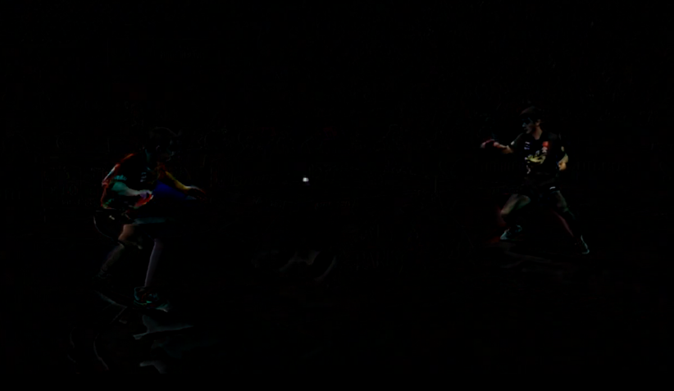

tailleMoy=19 : 
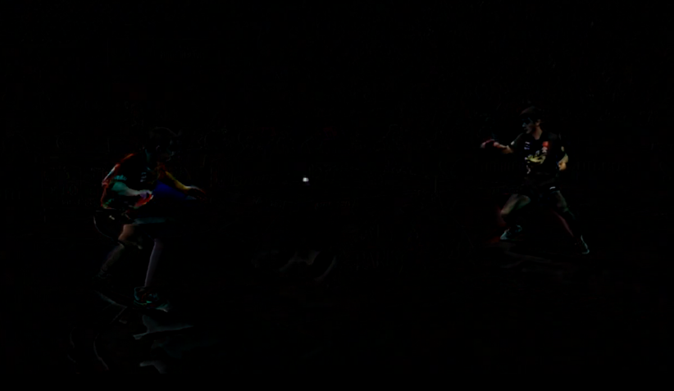


### Travail sur une vidéo enregistrée
#### Première vidéo
On a d’abord testé le programme sur cette vidéo  et obtenu le résultat suivant:

In [31]:
%%HTML
<video width="80%" controls>
  <source src="Table Tennis in Slow Motion.mp4" type="video/mp4">
</video>

In [33]:
from IPython.display import HTML

HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="videoSub.mp4" type="video/mp4">
</video></div>""")

La vidéo étant ralentie, on n’a pas d’effet de trainée de la balle et on voit bien que la soustraction de l’image moyenne fonctionne très bien. La seconde vidéo vise à montrer que cela n‘est en réalité pas problématique.

#### Deuxième vidéo
Cette vidéo est un jeu en vitesse réel. On obtient les résultats suivants avec tailleMoy=9 et tailleMoy=3

In [24]:
from IPython.display import Video

Video("TT Real Speed",embed=True)
Video("SUB9 TT Real Speed",embed=True)
Video("SUB3 TT Real Speed",embed=True)

La vitesse de la balle n’a pas d’impact sur la soustraction de l’image moyenne. On retrouve cependant l’impact de la variable tailleMoy (« aura » autour des joueurs très visible sur la première vidéo).
Enfin il est primordial de noter que la table étant immobile, elle est effacée lors de la soustraction. La détection d’un rebond est donc plus difficile puisque l’on ne peut se baser que sur la trajectoire de la balle et pas sur un contact visible de la balle et de la table.